In [1]:
import pandas as pd
import time
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
import os

# Go up one directory to get to master/
project_root = str(Path.cwd().parent)
sys.path.append(project_root)


In [2]:
def get_solutions_all_folds_rollOCT(name_dataset: str, depth=8, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/pulp/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

#sol_dict = get_solutions_all_folds_pulp(name_dataset=name_dataset, depth= max_depth_available)

#print(sol_dict[4][8]['train'])

In [3]:
def get_solutions_all_folds_cart(name_dataset: str, depth=8, folds_available = 10) -> dict: #for 10 fold cross valdidation, carefull that trees have min depth 2
    sol_dict = {} # one entry for every fold, [fold][depth]['test'] for train_data classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        for j in range(2,depth+1):
            sol_dict[i][j] = {}
            sol_dict[i][j]['test'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_test.csv")
            sol_dict[i][j]['train'] = pd.read_csv(f"../results/{name_dataset}/cart/fold{i}/depth{j}_classification_{name_dataset}_train.csv")
    return sol_dict

In [4]:
# get mcc list (one entry per fold) for specific depth 
def get_mcc_list(dataset_name, max_tree_depth, depth, folds_available, cart = False):
    if cart == False:
        sol_dict = get_solutions_all_folds_rollOCT(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)
    else:
        sol_dict = get_solutions_all_folds_cart(name_dataset = dataset_name, depth=max_tree_depth, folds_available = folds_available)

    mcc_scores_test = []
    mcc_scores_train = []

    for fold in range(1, folds_available+1):
        
        y_true_test = sol_dict[fold][depth]['test']['y']
        y_predict_test = sol_dict[fold][depth]['test']['prediction']

        y_true_train = sol_dict[fold][depth]['train']['y']
        y_predict_train = sol_dict[fold][depth]['train']['prediction']
        
        mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
        mcc_train = matthews_corrcoef(y_true_train, y_predict_train)

        mcc_scores_test.append(mcc_test)
        mcc_scores_train.append(mcc_train)
    
    return mcc_scores_test, mcc_scores_train

In [5]:
def mcc_dict_all_data(list_names, max_tree_depth, depth, folds, cart = False):
    mcc_dict = dict() #entry contains list with #folds values
    for i, name in enumerate(list_names):
        mcc_dict[name] = dict()
        #mcc_dict[name]['test'] = dict()
        #mcc_dict[name]['train'] = dict()
        mcc_scores_test, mcc_scores_train = get_mcc_list(dataset_name = name, max_tree_depth = max_tree_depth, depth = depth, folds_available = folds, cart = cart)
        mcc_dict[name]['test'] = mcc_scores_test
        mcc_dict[name]['train'] = mcc_scores_train
    return mcc_dict



In [6]:
mcc_dict_adult = mcc_dict_all_data(list_names=['adult'], max_tree_depth=8, depth=8, folds=10, cart=False)

print(mcc_dict_adult)

{'adult': {'test': [0.4967923314233742, 0.5427026082640887, 0.5387627033484016, 0.49743066792969604, 0.5286177599587909, 0.5110969066080021, 0.5343976104954412, 0.5238374686955704, 0.49698971051155627, 0.5145937697005561], 'train': [0.5516008110217042, 0.5481153141775077, 0.5398901000986964, 0.5499470759894903, 0.54844586213614, 0.5369164621162054, 0.5375762979611112, 0.5468075082989489, 0.5478837423274914, 0.5466030878023052]}}


In [7]:
def figure_mcc_matplotlib(list_names, max_tree_depth, depth, folds, cart = False, in_sample = False, alias_dict = dict()):
    mcc_dict = mcc_dict_all_data(list_names = list_names, max_tree_depth = max_tree_depth, depth = depth, folds = folds, cart = cart)
    data = []
    n_list = []
    for key in alias_dict:
        n_list.append(alias_dict[key])
    if cart == False:
        method_name = 'rollOCT'
    else: 
        method_name = 'cart'
    if in_sample == False:
        var = 'test'
        var_name = 'out-of-sample'
    else:
        var = 'train'
        var_name = 'in-sample'
    for i,name in enumerate(list_names):
            data.append(mcc_dict[name][var])
    plt.figure(figsize=(12, 6))
    plt.boxplot(data, tick_labels=n_list)
    plt.ylabel("mcc")
    plt.title(f"{method_name} {var_name} mcc depth {depth}")
    plt.show()

In [8]:
import seaborn as sns

def figure_mcc_seaborne(list_names, max_tree_depth, depth, folds, cart = False, in_sample = False, alias_dict = dict()):
    mcc_dict = mcc_dict_all_data(list_names = list_names, max_tree_depth = max_tree_depth, depth = depth, folds = folds, cart = cart)
    df = pd.DataFrame()
    if cart == False:
        method_name = 'rollOCT'
    else: 
        method_name = 'cart'
    if in_sample == False:
        var = 'test'
        var_name = 'out-of-sample'
    else:
        var = 'train'
        var_name = 'in-sample'
    for i,name in enumerate(list_names):
            df[alias_dict[name]] = mcc_dict[name][var]
    df_melted = pd.melt(df, var_name='Dataset', value_name='mcc')
    fig = plt.figure(figsize=(12, 6))
    sns.boxplot(x='Dataset',
                y='mcc',
                hue = 'Dataset',
                legend=False,
                data=df_melted,
                linewidth=1.3,       # thicker box lines
                #notch=True,        # notched boxplot
                width=0.6,         # narrower boxes
                #palette="Set2",     # color palette
                #medianprops={'color': 'red', 'linewidth': 1},
                #meanprops={'marker': 'D', 'markerfacecolor': 'blue', 'markeredgecolor': 'black', 'markersize': 8} # Mean shown as blue diamond
                )    
    plt.title(f"{method_name} {var_name} mcc depth {depth}")
    fig.savefig(os.path.join('../results', f'box_{method_name}_{depth}.png'))
    plt.show()

In [9]:
list_names = ['adult', 'breast+cancer+wisconsin+diagnostic', 'car_evaluation', 'mushroom', 'nursery', 'seismic', 'spambase', 'wine', 'banknote+authentication', 'chess+king+rook+vs+king+pawn', 'monk1', 'monk2', 'monk3']

alias_dict = {
    'adult' : 'adult',
    'breast+cancer+wisconsin+diagnostic' : 'bcwd',
    'car_evaluation' : 'car_eval',
    'mushroom' : 'mushroom',
    'nursery' : 'nursery',
    'seismic' : 'seismic',
    'spambase' : 'spambase',
    'wine' : 'wine',
    'banknote+authentication' : 'banknote',
    'chess+king+rook+vs+king+pawn' : 'chess',
    'monk1' : 'monk1',
    'monk2' : 'monk2',
    'monk3' : 'monk3'
}

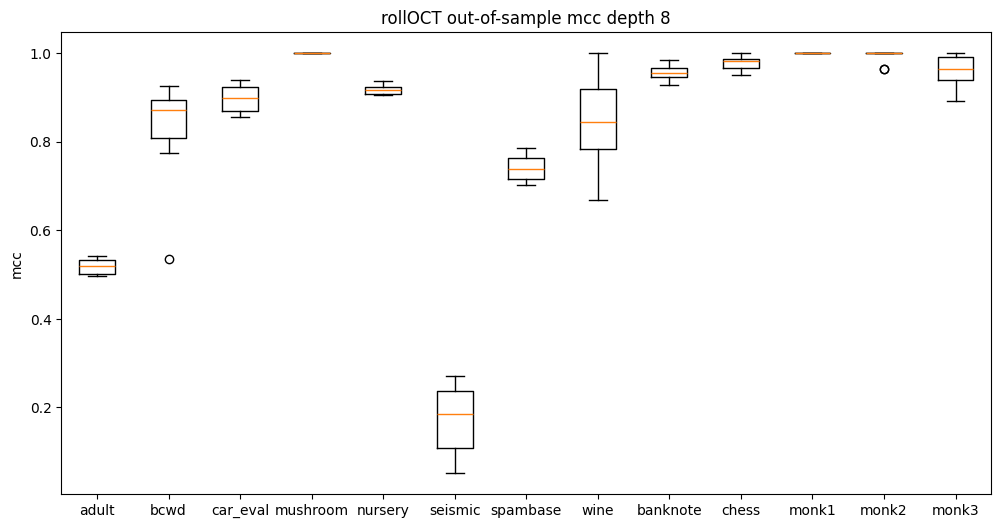

In [10]:
figure_mcc_matplotlib(list_names, max_tree_depth = 8, depth=8, folds=10, cart = False, in_sample = False, alias_dict=alias_dict)

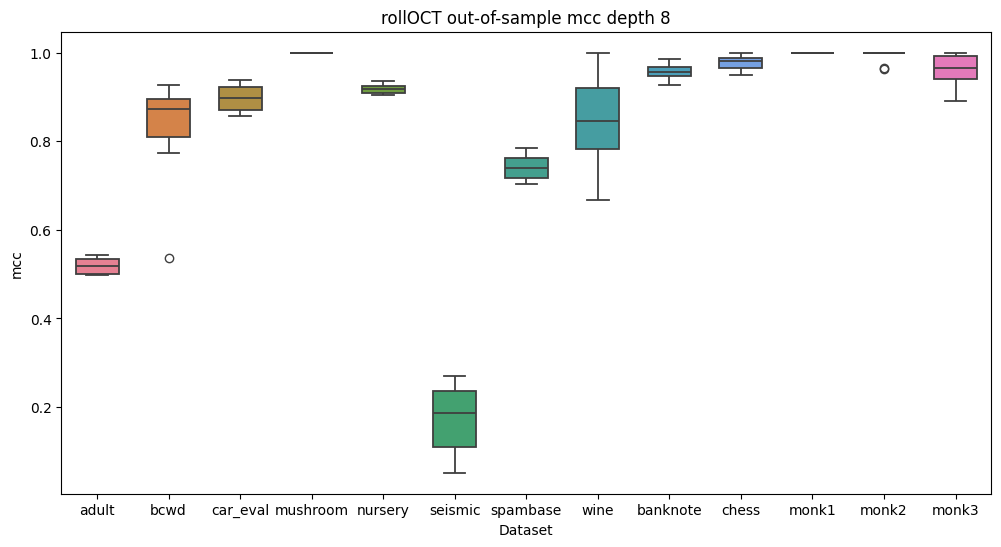

In [11]:
figure_mcc_seaborne(list_names, max_tree_depth = 8, depth=8, folds=10, cart = False, in_sample = False, alias_dict=alias_dict)

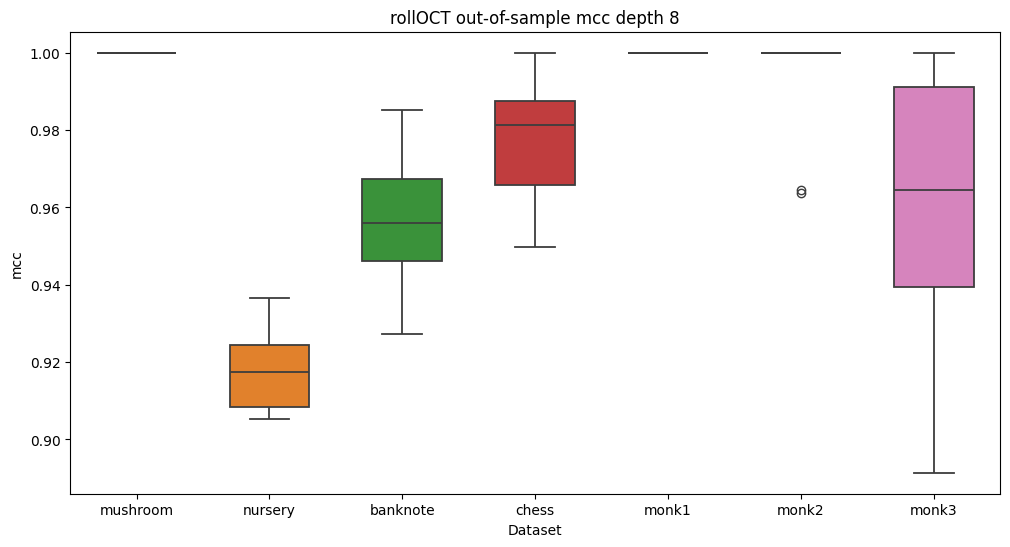

In [12]:
list_names_close = ['mushroom', 'nursery', 'banknote+authentication', 'chess+king+rook+vs+king+pawn', 'monk1', 'monk2', 'monk3']

figure_mcc_seaborne(list_names_close, max_tree_depth = 8, depth=8, folds=10, cart = False, in_sample = False, alias_dict=alias_dict)

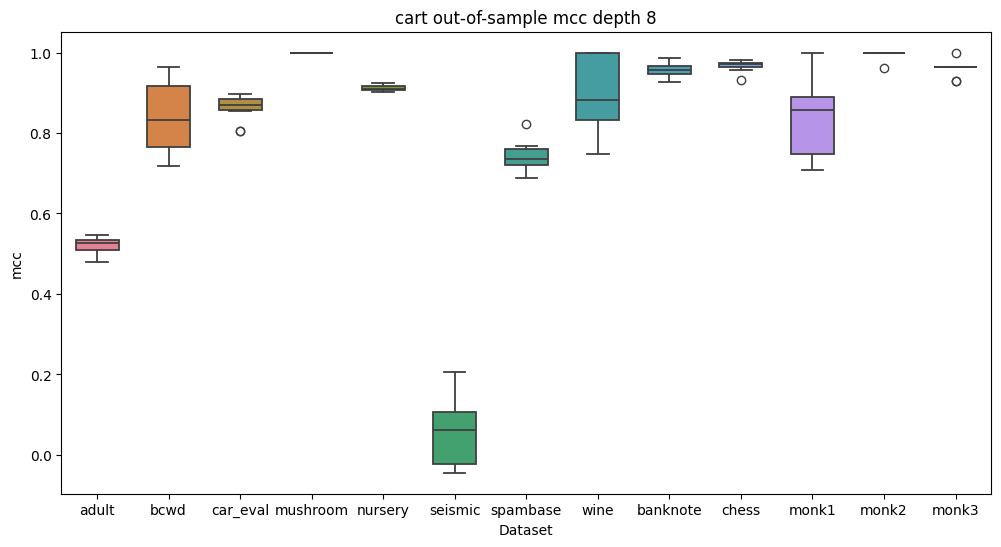

In [13]:
figure_mcc_seaborne(list_names, max_tree_depth = 8, depth=8, folds=10, cart = True, in_sample = False, alias_dict=alias_dict)

Für forest

In [14]:
def get_solutions_all_folds_less_random_forest(name_dataset: str, n_estimators = 50, depth=8, folds_available = 5, runs = 5) -> dict: #depth is the depth used for the forests
    sol_dict = {} # one entry for every fold, [fold] for classification for fold of depth; same for training
    for run in range(1,runs+1):
        sol_dict[run] = {}
        for i in range(1,folds_available+1):
            #sol_dict[i] = {}
            sol_dict[run][i] = pd.read_csv(f"../results/less_random_forest_{name_dataset}/n_est{n_estimators}_depth{depth}/fold{i}/{name_dataset}_result_test_run{run}.csv")
    return sol_dict

def get_mcc_list_less_random_forest(dataset_name, depth_of_tree, folds_available, n_estimators = 50, runs = 5):
    sol_dict = get_solutions_all_folds_less_random_forest(name_dataset = dataset_name, depth=depth_of_tree, folds_available = folds_available, n_estimators=n_estimators)
    
    mcc_scores = []

    for run in range(1, runs+1):
        run_mcc_list = [] #mcc's over all folds for this run
        for fold in range(1, folds_available+1):
            
            y_true_test = sol_dict[run][fold]['y']
            y_predict_test = sol_dict[run][fold]['prediction']

            
            mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
            run_mcc_list.append(mcc_test)
        avg_mcc_run = np.mean(run_mcc_list)
        mcc_scores.append(avg_mcc_run)
    return mcc_scores

In [15]:
def get_solutions_all_sklearn_random_forest(name_dataset: str, n_estimators = 50, depth=8, folds_available = 5, runs = 5) -> dict: #depth is the depth used for the forests
    sol_dict = {} # one entry for every run, all fold, [run][fold] for classification for fold of depth; same for training
    for run in range(1,runs+1):
        sol_dict[run] = {}
        for i in range(1,folds_available+1):
            #sol_dict[run][i] = {}
            sol_dict[run][i] = pd.read_csv(f"../results/scikit_learn_forest/{name_dataset}/n_est{n_estimators}_depth{depth}/fold{i}/{name_dataset}_result_test_run{run}.csv")
    return sol_dict

def get_mcc_list_sklearn_random_forest(dataset_name, depth_of_tree, folds_available, n_estimators = 50, runs = 5):
    sol_dict = get_solutions_all_sklearn_random_forest(name_dataset = dataset_name, depth=depth_of_tree, folds_available = folds_available, n_estimators=n_estimators, runs = runs)
    
    mcc_scores = []

    for run in range(1, runs+1):
        run_mcc_list = [] #mcc's over all folds for this run
        for fold in range(1, folds_available+1):
            
            y_true_test = sol_dict[run][fold]['y']
            y_predict_test = sol_dict[run][fold]['prediction']

            
            mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
            run_mcc_list.append(mcc_test)
        avg_mcc_run = np.mean(run_mcc_list)
        mcc_scores.append(avg_mcc_run)
    return mcc_scores

In [16]:
def get_solutions_all_folds_refact_tree(name_dataset: str, depth=8, folds_available = 10) -> dict: #depth is the depth used for the forests
    sol_dict = {} # one entry for every fold, [fold] for classification for fold of depth; same for training
    for i in range(1,folds_available+1):
        sol_dict[i] = {}
        sol_dict[i] = pd.read_csv(f"../results/{name_dataset}_refactored_tree_pulp/fold{i}/{name_dataset}_result_test.csv")
    return sol_dict

def get_mcc_list_refact_tree(dataset_name, depth_of_tree, folds_available):
    sol_dict = get_solutions_all_folds_refact_tree(name_dataset = dataset_name, depth=depth_of_tree, folds_available = folds_available)
    
    mcc_scores = []

    for fold in range(1, folds_available+1):
        
        y_true_test = sol_dict[fold]['y']
        y_predict_test = sol_dict[fold]['prediction']

        
        mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes

        mcc_scores.append(mcc_test)
    
    return mcc_scores

In [17]:
def get_solutions_refactored_random_forest(name_dataset: str, n_estimators = 50, depth=8, folds_available = 5, runs = 5) -> dict: #depth is the depth used for the forests
    sol_dict = {} # one entry for every run, all fold, [run][fold] for classification for fold of depth; same for training
    for run in range(1,runs+1):
        sol_dict[run] = {}
        for i in range(1,folds_available+1):
            #sol_dict[run][i] = {}
            sol_dict[run][i] = pd.read_csv(f"../results/refactored_random_forest/{name_dataset}/n_est{n_estimators}_depth{depth}/fold{i}/{name_dataset}_result_test_run{run}.csv")
    return sol_dict

def get_mcc_list_refactored_random_forest(dataset_name, depth_of_tree, folds_available, n_estimators = 50, runs = 5):
    sol_dict = get_solutions_refactored_random_forest(name_dataset = dataset_name, depth=depth_of_tree, folds_available = folds_available, n_estimators=n_estimators, runs = runs)
    
    mcc_scores = []

    for run in range(1, runs+1):
        run_mcc_list = [] #mcc's over all folds for this run
        for fold in range(1, folds_available+1):
            
            y_true_test = sol_dict[run][fold]['y']
            y_predict_test = sol_dict[run][fold]['prediction']

            
            mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
            run_mcc_list.append(mcc_test)
        avg_mcc_run = np.mean(run_mcc_list)
        mcc_scores.append(avg_mcc_run)
    return mcc_scores

In [18]:
def mcc_dict_all_data_with_forest(list_names, depth, folds_tree, folds_forest, n_estimators = 50, runs_forest =5):
    mcc_dict = dict() #entry contains list with #folds values
    for i, name in enumerate(list_names):
        mcc_dict[name] = dict()
        mcc_scores_test_rollOCT, mcc_scores_train_rollOCT = get_mcc_list(dataset_name = name, max_tree_depth = depth, depth = depth, folds_available = folds_tree, cart = False)
        mcc_scores_test_cart, mcc_scores_train_cart = get_mcc_list(dataset_name = name, max_tree_depth = depth, depth = depth, folds_available = folds_tree, cart = True)
        mcc_scores_lr_forest = get_mcc_list_less_random_forest(dataset_name= name, depth_of_tree=depth, folds_available=folds_forest, n_estimators=n_estimators)
        mcc_scores_sklearn_forest = get_mcc_list_sklearn_random_forest(dataset_name= name, depth_of_tree=depth, folds_available=folds_forest, n_estimators=n_estimators, runs=runs_forest)
        mcc_scores_refac_tree = get_mcc_list_refact_tree(dataset_name = name, depth_of_tree = depth, folds_available = folds_tree)
        mcc_scores_refac_forest = get_mcc_list_refactored_random_forest(dataset_name= name, depth_of_tree=depth, folds_available=folds_forest, n_estimators=n_estimators, runs=runs_forest)
        mcc_dict[name]['original_rollOCT'] = mcc_scores_test_rollOCT
        mcc_dict[name]['cart'] = mcc_scores_test_cart
        mcc_dict[name]['less_random_forest'] = mcc_scores_lr_forest
        mcc_dict[name]['sklearn_random_forest'] = mcc_scores_sklearn_forest
        mcc_dict[name]['refactored_rollOCT'] = mcc_scores_refac_tree
        mcc_dict[name]['refactored_random_forest'] = mcc_scores_refac_forest
    return mcc_dict

In [19]:
import seaborn as sns

def figure_mcc_seaborne_all(list_names, depth, alias_dict = dict(), n_estimators_forest = 50, folds_tree = 10, folds_forest = 5):
    mcc_dict = mcc_dict_all_data_with_forest(list_names = list_names, depth = depth, folds_tree = folds_tree, folds_forest=folds_forest, n_estimators=n_estimators_forest)
    data = []
    for name in list_names:
        for mcc_type in ['cart', 'original_rollOCT', 'refactored_rollOCT', 'sklearn_random_forest', 'less_random_forest', 'refactored_random_forest']:
            for value in mcc_dict[name][mcc_type]:
                data.append({
                    'Dataset': alias_dict.get(name, name),
                    'Type': mcc_type,
                    'mcc': value
                })
    df = pd.DataFrame(data)

    print(data)

    fig = plt.figure(figsize=(15, 6))
    sns.boxplot(x='Dataset', y='mcc', hue='Type', data=df, linewidth=1, width=0.6, dodge=True, palette='colorblind')
    plt.title(f"mcc; tree depth {depth}, {n_estimators_forest} estimators in forest")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.savefig(os.path.join('../results', f'box_all_depth{depth}_n{n_estimators_forest}.png'))
    plt.show()

In [20]:
list_names = ['adult', 'breast+cancer+wisconsin+diagnostic', 'car_evaluation', 'mushroom', 'nursery', 'seismic', 'spambase', 'wine', 'banknote+authentication', 'chess+king+rook+vs+king+pawn', 'monk1', 'monk2', 'monk3']

alias_dict = {
    'adult' : 'adult',
    'breast+cancer+wisconsin+diagnostic' : 'bcwd',
    'car_evaluation' : 'car_eval',
    'mushroom' : 'mushroom',
    'nursery' : 'nursery',
    'seismic' : 'seismic',
    'spambase' : 'spambase',
    'wine' : 'wine',
    'banknote+authentication' : 'banknote',
    'chess+king+rook+vs+king+pawn' : 'chess',
    'monk1' : 'monk1',
    'monk2' : 'monk2',
    'monk3' : 'monk3'
}

[{'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.479186564424878}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5353664018008605}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5467009558583029}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5002705138847823}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5306363830263271}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5200681700419525}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5451541871983449}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5320049404824283}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5063720578046123}, {'Dataset': 'adult', 'Type': 'cart', 'mcc': 0.5160133842393329}, {'Dataset': 'adult', 'Type': 'original_rollOCT', 'mcc': 0.4967923314233742}, {'Dataset': 'adult', 'Type': 'original_rollOCT', 'mcc': 0.5427026082640887}, {'Dataset': 'adult', 'Type': 'original_rollOCT', 'mcc': 0.5387627033484016}, {'Dataset': 'adult', 'Type': 'original_rollOCT', 'mcc': 0.49743066792969604}, {'Dataset': 'adult', 'Type': 'original_ro

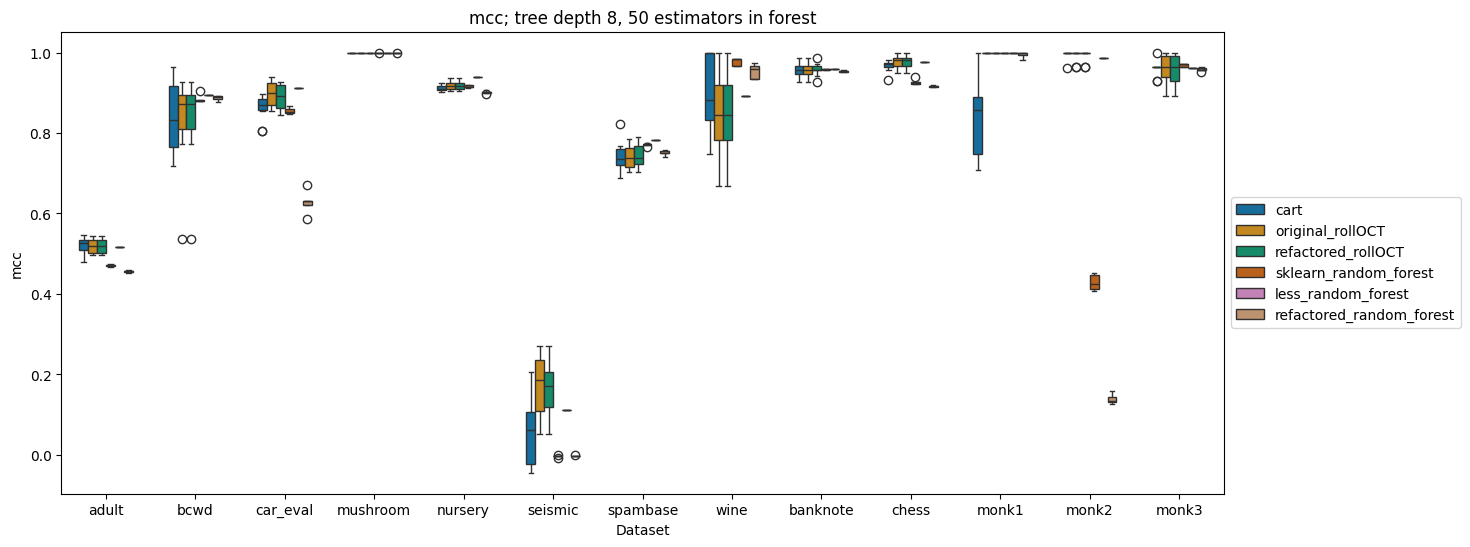

In [21]:
figure_mcc_seaborne_all(list_names = list_names, depth=8, alias_dict = alias_dict, n_estimators_forest = 50, folds_tree = 10, folds_forest = 5)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def figure_mcc_seaborne_all(
    list_names, 
    depth, 
    alias_dict = dict(), 
    n_estimators_forest = 50, 
    folds_tree = 10, 
    folds_forest = 5
):
    mcc_dict = mcc_dict_all_data_with_forest(
        list_names = list_names, 
        depth = depth, 
        folds_tree = folds_tree, 
        folds_forest = folds_forest, 
        n_estimators = n_estimators_forest
    )
    data = []
    for name in list_names:
        for mcc_type in ['cart', 'rollOCT', 'less_random_forest']:
            for value in mcc_dict[name][mcc_type]:
                data.append({
                    'Dataset': alias_dict.get(name, name),  # Ensures alias is used
                    'Type': mcc_type,
                    'mcc': value
                })
    df = pd.DataFrame(data)

    print(data)

    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(
        x='Dataset', 
        y='mcc', 
        hue='Type', 
        data=df, 
        linewidth=1.3, 
        width=0.6
    )
    plt.title(f"mcc; tree depth {depth}, {n_estimators_forest} estimators in forest")
    plt.xticks(rotation=30)  # For readable x-axis
    plt.tight_layout()
    plt.savefig(os.path.join('../results', f'box_all_depth{depth}_n{n_estimators_forest}.png'))
    plt.show()

In [23]:
#figure_mcc_seaborne_all(list_names = list_names, depth=8, alias_dict = alias_dict, n_estimators_forest = 50, folds_tree = 10, folds_forest = 5)

taxa easy estimators

In [24]:
def get_solutions_random_rollOCT_forests(n_estimators = 50, depth=8, folds_available = 5, runs = 5, max_features = None) -> dict: #depth is the depth used for the forests
    if max_features == None:
        sub_name = 'None'
    else:
        sub_name = max_features
    
    sol_dict = {} # one entry for every run, all fold, [run][fold] for classification for fold of depth; same for training
    for run in range(1,runs+1):
        sol_dict[run] = {}
        for i in range(1,folds_available+1):
            sol_dict[run][i] = pd.read_csv(f"../microbiome_data/taxa_easy/refactored_random_forest/n{n_estimators}_d{depth}_{sub_name}/fold{i}/result_test_run{run}.csv")
    return sol_dict

def get_solutions_random_sklearn_forests(n_estimators = 50, depth=8, folds_available = 5, runs = 5, max_features = None) -> dict: #depth is the depth used for the forests
    if max_features == None:
        sub_name = 'None'
    else:
        sub_name = max_features
    
    sol_dict = {} # one entry for every run, all fold, [run][fold] for classification for fold of depth; same for training
    for run in range(1,runs+1):
        sol_dict[run] = {}
        for i in range(1,folds_available+1):
            sol_dict[run][i] = pd.read_csv(f"../microbiome_data/taxa_easy/sklearn_random_forest/n{n_estimators}_d{depth}_{sub_name}/fold{i}/result_test_run{run}.csv")
    return sol_dict

def get_mcc_list_rollOCT_random_forests(depth_of_tree, folds_available, n_estimators = 50, runs = 5, max_features = None):
    sol_dict = get_solutions_random_rollOCT_forests(n_estimators=n_estimators, depth=depth_of_tree, folds_available = folds_available, runs = runs,  max_features =  max_features)
    
    mcc_scores = []

    for run in range(1, runs+1):
        run_mcc_list = [] #mcc's over all folds for this run
        for fold in range(1, folds_available+1):
            
            y_true_test = sol_dict[run][fold]['y']
            y_predict_test = sol_dict[run][fold]['prediction']

            
            mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
            run_mcc_list.append(mcc_test)
        avg_mcc_run = np.mean(run_mcc_list)
        mcc_scores.append(avg_mcc_run)
    return mcc_scores

def get_mcc_list_sklearn_random_forests(depth_of_tree, folds_available, n_estimators = 50, runs = 5, max_features = None):
    sol_dict = get_solutions_random_sklearn_forests(n_estimators=n_estimators, depth=depth_of_tree, folds_available = folds_available, runs = runs,  max_features =  max_features)
    
    mcc_scores = []

    for run in range(1, runs+1):
        run_mcc_list = [] #mcc's over all folds for this run
        for fold in range(1, folds_available+1):
            
            y_true_test = sol_dict[run][fold]['y']
            y_predict_test = sol_dict[run][fold]['prediction']

            
            mcc_test = matthews_corrcoef(y_true_test, y_predict_test) #For a multiclass problem, sklearn.metrics.matthews_corrcoef returns a single float value representing the overall Matthews correlation coefficient (MCC) across all classes
            run_mcc_list.append(mcc_test)
        avg_mcc_run = np.mean(run_mcc_list)
        mcc_scores.append(avg_mcc_run)
    return mcc_scores

In [25]:
def mcc_dict_all_data_taxa_easy_forest(estimator_list, depth, folds_forest, runs_forest =5, max_features = 'sqrt'):
    mcc_dict = dict() #entry contains list with #folds values
    for i, n_estimators in enumerate(estimator_list):
        mcc_dict[n_estimators] = dict()
        mcc_scores_rollOCT_forest = get_mcc_list_rollOCT_random_forests(depth_of_tree = depth, folds_available = folds_forest, n_estimators = n_estimators, runs = runs_forest, max_features= max_features)
        mcc_scores_sklearn_rollOCT = get_mcc_list_sklearn_random_forests(depth_of_tree = depth, folds_available = folds_forest, n_estimators = n_estimators, runs = runs_forest, max_features= max_features)
        mcc_dict[n_estimators]['rollOCT_forest'] = mcc_scores_rollOCT_forest
        mcc_dict[n_estimators]['sklearn_forest'] = mcc_scores_sklearn_rollOCT
    return mcc_dict

In [26]:
import seaborn as sns

def figure_mcc_seaborne_tasxa_easy_estimators(list_names, depth, alias_dict = dict(), folds_forest =  5, runs_forest = 5, max_features= None):
    data = []
    mcc_dict = mcc_dict_all_data_taxa_easy_forest(estimator_list = list_names, depth=depth, folds_forest = folds_forest, runs_forest =runs_forest, max_features= max_features)
    for name in list_names:
        for mcc_type in ['sklearn_forest', 'rollOCT_forest']:
            for value in mcc_dict[name][mcc_type]:
                data.append({
                    'n_estimators': alias_dict.get(name, name),
                    'Type': mcc_type,
                    'mcc': value
                })
    df = pd.DataFrame(data)

    print(data)

    fig = plt.figure(figsize=(15, 6))
    plt.ylim(0, 1)
    sns.boxplot(x='n_estimators', y='mcc', hue='Type', data=df, linewidth=1, width=0.6, dodge=True, palette='colorblind')
    plt.title(f"taxa china3; mcc; tree depth {depth}")
    fig.savefig(os.path.join('../microbiome_data/taxa_easy', f'box_multi_estimators_depth{depth}.png'))
    plt.show()

In [27]:
estimators_list = [50, 100, 200, 500, 600, 800, 1000]

alias_dict = {
    50 : '50',
    100 : '100',
    200 : '200',
    500 : '500',
    600 : '600',
    800 : '800',
    1000 : '1000',
}

[{'n_estimators': '50', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7384317995297025)}, {'n_estimators': '50', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7262707594114045)}, {'n_estimators': '50', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7208229292309857)}, {'n_estimators': '50', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7063533905212431)}, {'n_estimators': '50', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7063416718771924)}, {'n_estimators': '50', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.5682146405343577)}, {'n_estimators': '50', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.5510899512406301)}, {'n_estimators': '50', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.6060397354140414)}, {'n_estimators': '50', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.4631319951364789)}, {'n_estimators': '50', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.601671277446994)}, {'n_estimators': '100', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7147979033002044)}, {'n_estimators': '10

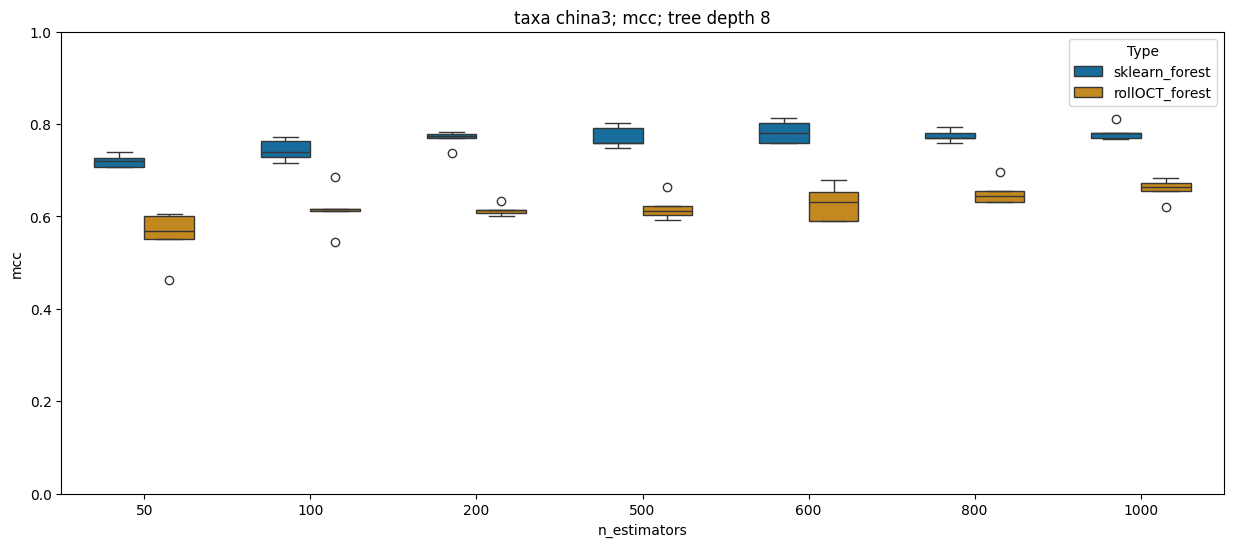

In [28]:
figure_mcc_seaborne_tasxa_easy_estimators(list_names = estimators_list, depth=8, alias_dict = alias_dict, folds_forest = 5, runs_forest=5, max_features= 'sqrt')

taxa easy depth

In [29]:
def mcc_dict_all_data_taxa_easy_forest_depths(n_estimators, depth_list, folds_forest, runs_forest =5, max_features = 'sqrt'):
    mcc_dict = dict() #entry contains list with #folds values
    for i, depth in enumerate(depth_list):
        mcc_dict[depth] = dict()
        mcc_scores_rollOCT_forest = get_mcc_list_rollOCT_random_forests(depth_of_tree = depth, folds_available = folds_forest, n_estimators = n_estimators, runs = runs_forest, max_features= max_features)
        mcc_scores_sklearn_rollOCT = get_mcc_list_sklearn_random_forests(depth_of_tree = depth, folds_available = folds_forest, n_estimators = n_estimators, runs = runs_forest, max_features= max_features)
        mcc_dict[depth]['rollOCT_forest'] = mcc_scores_rollOCT_forest
        mcc_dict[depth]['sklearn_forest'] = mcc_scores_sklearn_rollOCT
    return mcc_dict

In [30]:
import seaborn as sns

def figure_mcc_seaborne_tasxa_easy_estimators(list_names, n_estimators, alias_dict = dict(), folds_forest =  5, runs_forest = 5, max_features= None):
    data = []
    mcc_dict = mcc_dict_all_data_taxa_easy_forest_depths(depth_list= list_names, n_estimators = n_estimators, folds_forest = folds_forest, runs_forest =runs_forest, max_features= max_features)
    for name in list_names:
        for mcc_type in ['sklearn_forest', 'rollOCT_forest']:
            for value in mcc_dict[name][mcc_type]:
                data.append({
                    'depth': alias_dict.get(name, name),
                    'Type': mcc_type,
                    'mcc': value
                })
    df = pd.DataFrame(data)

    print(data)

    fig = plt.figure(figsize=(15, 6))
    plt.ylim(0, 1)
    sns.boxplot(x='depth', y='mcc', hue='Type', data=df, linewidth=1, width=0.6, dodge=True, palette='colorblind')
    plt.title(f"taxa china3; mcc; {n_estimators} estimators")
    fig.savefig(os.path.join('../microbiome_data/taxa_easy', f'box_{n_estimators}estimators_multi_depth.png'))
    plt.show()

In [31]:
depth_list = [4, 6, 8, 10, 12]

alias_dict = {
    4 : '4',
    6 : '6',
    8 : '8',
    10 : '10',
    12 : '12'
}

[{'depth': '4', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7590682397711719)}, {'depth': '4', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7261964059713332)}, {'depth': '4', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7479116633960292)}, {'depth': '4', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7621987593071472)}, {'depth': '4', 'Type': 'sklearn_forest', 'mcc': np.float64(0.8010258920796449)}, {'depth': '4', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.6217920304752016)}, {'depth': '4', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.6529860333738741)}, {'depth': '4', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.6225111575143715)}, {'depth': '4', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.6238973101077162)}, {'depth': '4', 'Type': 'rollOCT_forest', 'mcc': np.float64(0.5907207523802331)}, {'depth': '6', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7599790838691656)}, {'depth': '6', 'Type': 'sklearn_forest', 'mcc': np.float64(0.7493949815321991)}, {'depth': '6', 'Type': 'skl

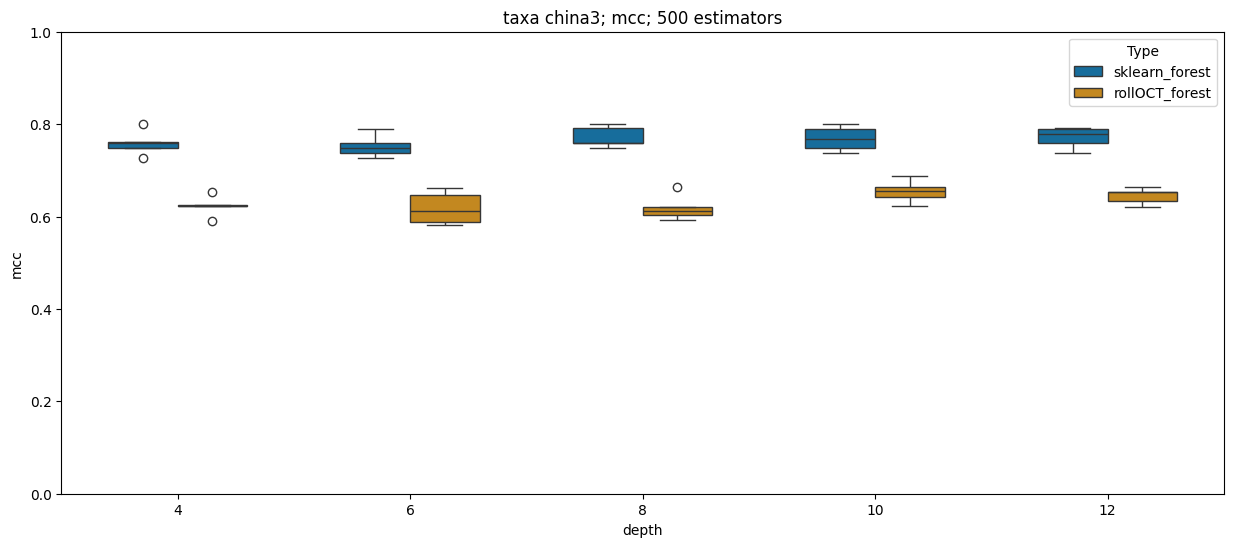

In [32]:
figure_mcc_seaborne_tasxa_easy_estimators(list_names = depth_list, n_estimators= 500, alias_dict = alias_dict, folds_forest = 5, runs_forest=5, max_features= 'sqrt')